In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/friend-data/Dataset/Test.csv
/kaggle/input/friend-data/Dataset/train.csv
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agx (73).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (16).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agz (19).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agz (46).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (87).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agx (81).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (66).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (95).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agz (7).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (118).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (101).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agy (27).jpg
/kaggle/input/friend-data/Dataset/Train Data/Train Data/agx (43).jpg
/kaggle/input/f

In [2]:

path= '/kaggle/input/friend-data/Dataset/'
k= '../input/friend-data/Dataset/train.csv'
p ='/kaggle/input/friend-data/Dataset/Test.csv'

In [3]:

train=pd.read_csv(k)
test=pd.read_csv(p)


In [4]:
del test['Category']

In [5]:
train.head(5),test.head(5)

(      Filename Category
 0  agx (1).jpg  Toddler
 1  agx (2).jpg  Toddler
 2  agx (3).jpg  Toddler
 3  agx (4).jpg  Toddler
 4  agx (5).jpg  Toddler,
       Filename
 0  Img1001.jpg
 1  Img1017.jpg
 2  Img1020.jpg
 3  Img1025.jpg
 4  Img1038.jpg)

In [6]:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

In [7]:

from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [8]:
import warnings
warnings.filterwarnings('ignore')


In [9]:
path ='/kaggle/input/friend-data/Dataset/Train Data/Train Data/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../../train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../../Test Data/Test Data')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

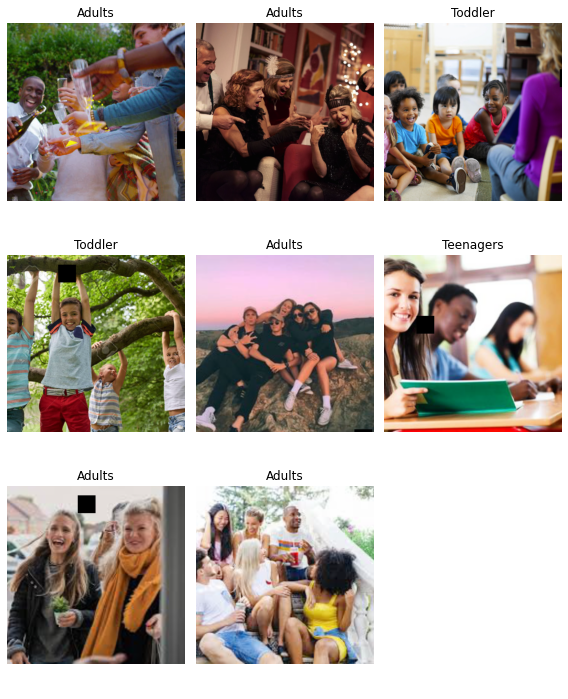

In [10]:

## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

In [11]:
## print the target classes
val=data.classes
print(val)

['Adults', 'Teenagers', 'Toddler']


In [12]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth


In [13]:
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/tmp/data010"

In [14]:

def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [15]:

class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
#Path(ROOT).mkdir(exist_ok=True, parents=True)
src1 = "/kaggle/input/friend-data/Dataset/"
shutil.copytree(src1, ROOT)

if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.Category))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="Train Data/Train Data/").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="Test Data/Test Data"))
        learn = cnn_learner(data, models.densenet169, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[cb])
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=[cb])
        learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[cb])
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(3, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)

In [ ]:

sub = test_df[["Filename"]]
sub["Category"] = np.argmax(test_preds, axis=1)

In [ ]:

y=[]
for i in sub['Category']:
    y.append(val[i])
sub['Category']=y

In [ ]:
sub.head(2)

In [ ]:
sub.to_csv("final.csv", index=False)